# **Project Title: Deep CSAT Project**

**by Shubham Pandey**

### **Project Summary:**

This project focuses on predicting Customer Satisfaction (CSAT) in an e-commerce setting using a combination of structured operational data and customer text feedback.
A full end-to-end machine learning pipeline was developed — from data preprocessing and exploratory data analysis (EDA) to model training, evaluation, and deployment through an interactive Streamlit web application.

***Key Steps***

1. Data Cleaning & Feature Engineering

    - Removed sparse and irrelevant columns (>70% missing).

    - Engineered features such as response_time_hrs, remarks_length, sentiment_score, and categorical encodings for agent shift, tenure, and channel.

    - Extracted sentiment polarity from customer remarks using TextBlob.

2. Exploratory Data Analysis (EDA)

    - Identified strong negative correlation between response time and CSAT.

    - Found that agent shift, tenure, and customer sentiment significantly influenced satisfaction.

    - Confirmed relationships statistically using ANOVA and Chi-Squared tests.

3. Model Building

    - Implemented hybrid pipelines combining TF-IDF text features, categorical one-hot encodings, and numeric scaling.

    - Trained multiple models: Logistic Regression, Random Forest, and XGBoost.

    - Achieved up to 88% accuracy (XGBoost) on the binary CSAT prediction (High vs. Low).

4. Deployment

    - Saved models and preprocessing pipelines with joblib.

    - Built an intuitive Streamlit app allowing users to input remark text and structured parameters to get real-time CSAT predictions with probabilities and feature importance visualizations.

#### **Github Repo:** https://github.com/Shubhampandey1git/Deep-CSAT-Project

## **Imports**

In [118]:
import pandas as pd
import numpy as np
import re, string
from datetime import datetime
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

import joblib
import json
import os

## **Data Loading & First Look**

In [85]:
df = pd.read_csv("..\data\eCommerce_Customer_support_data.csv")
df.head()

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


- Description and info

In [86]:
display(df.describe())
display(df.info())

,Item_price,connected_handling_time,CSAT Score
count,17206.000000,242.000000,85907.000000
mean,5660.774846,462.400826,4.242157
std,12825.728411,246.295037,1.378903
min,0.000000,0.000000,1.000000
25%,392.000000,293.000000,4.000000
50%,979.000000,427.000000,5.000000
75%,2699.750000,592.250000,5.000000
max,164999.000000,1986.000000,5.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

None

## **Data Cleaning**

In [87]:
# Dropping cols with >70% missing values
missing_per = df.isnull().mean() * 100
drop_cols = missing_per[missing_per > 70].index.tolist()
print("Dropping cols with >70% missing: ", drop_cols)
df.drop(columns=drop_cols, inplace=True, errors='ignore')

Dropping cols with >70% missing:  ['order_date_time', 'Customer_City', 'Product_category', 'Item_price', 'connected_handling_time']


In [88]:
# Dropping irrelevant IDs
df.drop(columns=['Unique id', 'Order_id'], inplace=True, errors='ignore')

# Replacing blanks with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Fill remaining object columns with 'Unknown'
for col in df.select_dtypes(include='object').columns:
    df[col].fillna('Unknown', inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\2772504143.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


In [89]:
# Dropping rows without CSAT (target)
df.dropna(subset=['CSAT Score'], inplace=True)
df['CSAT Score'] = df['CSAT Score'].astype(int)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channel_name          85907 non-null  object
 1   category              85907 non-null  object
 2   Sub-category          85907 non-null  object
 3   Customer Remarks      85907 non-null  object
 4   Issue_reported at     85907 non-null  object
 5   issue_responded       85907 non-null  object
 6   Survey_response_Date  85907 non-null  object
 7   Agent_name            85907 non-null  object
 8   Supervisor            85907 non-null  object
 9   Manager               85907 non-null  object
 10  Tenure Bucket         85907 non-null  object
 11  Agent Shift           85907 non-null  object
 12  CSAT Score            85907 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 8.5+ MB


None

## **Feature Engineering**

In [90]:
# Convert datetime columns
for c in ['Issue_reported at', 'issue_responded', 'Survey_response_Date']:
    df[c] = pd.to_datetime(df[c], errors='coerce')

# Response time gap (in hours)
df['response_time_hrs'] = (df['issue_responded'] - df['Issue_reported at']).dt.total_seconds() / 3600
df['response_time_hrs'].fillna(df['response_time_hrs'].median(), inplace=True)

# Temporal features
df['hour_reported'] = df['Issue_reported at'].dt.hour
df['day_of_week'] = df['Issue_reported at'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

# Handle Customer Remarks text
def clean_text(text):
    if pd.isnull(text) or text == 'Unknown': return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_remarks'] = df['Customer Remarks'].astype(str).apply(clean_text)
df['has_remarks'] = df['Customer Remarks'].notna().astype(int)
df['remarks_length'] = df['clean_remarks'].apply(len)

# Sentiment
def get_sentiment(text):
    if not text: return 0
    return TextBlob(text).sentiment.polarity

df['sentiment_score'] = df['clean_remarks'].apply(get_sentiment)
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce').fillna(0)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\895137672.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\895137672.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['response_time_hrs'].fillna(df['response_time_hrs'].median(), inplace=True)


In [91]:
# Keeping only Useful Cols
keep_cols = [
    'channel_name', 'category', 'Sub-category',
    'Agent_name', 'Supervisor', 'Manager',
    'Tenure Bucket', 'Agent Shift',
    'response_time_hrs', 'hour_reported', 'day_of_week', 'is_weekend',
    'has_remarks', 'remarks_length', 'sentiment_score',
    'clean_remarks', 'CSAT Score'
]

df = df[keep_cols].copy()

print("Final cleaned dataset shape:", df.shape)
print("Columns kept:\n", df.columns.tolist())

Final cleaned dataset shape: (85907, 17)
Columns kept:
 ['channel_name', 'category', 'Sub-category', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift', 'response_time_hrs', 'hour_reported', 'day_of_week', 'is_weekend', 'has_remarks', 'remarks_length', 'sentiment_score', 'clean_remarks', 'CSAT Score']


## **EDA**

- Basic Setup

In [92]:
plt.style.use('seaborn-v0_8-whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Check the first few rows
df.head()

,channel_name,category,Sub-category,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,response_time_hrs,hour_reported,day_of_week,is_weekend,has_remarks,remarks_length,sentiment_score,clean_remarks,CSAT Score
0,Outcall,Product Queries,Life Insurance,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,0.566667,11.0,6.0,1,1,0,0.0,,5
1,Outcall,Product Queries,Product Specific Information,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,0.033333,12.0,6.0,1,1,0,0.0,,5
2,Inbound,Order Related,Installation/demo,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,0.366667,20.0,6.0,1,1,0,0.0,,5
3,Inbound,Returns,Reverse Pickup Enquiry,Patrick Flores,Olivia Wang,John Smith,>90,Evening,0.333333,20.0,6.0,1,1,0,0.0,,5
4,Inbound,Cancellation,Not Needed,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,0.033333,10.0,6.0,1,1,0,0.0,,5


#### **CSAT Distribution Overview**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1026196672.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CSAT Score', data=df, palette='viridis')


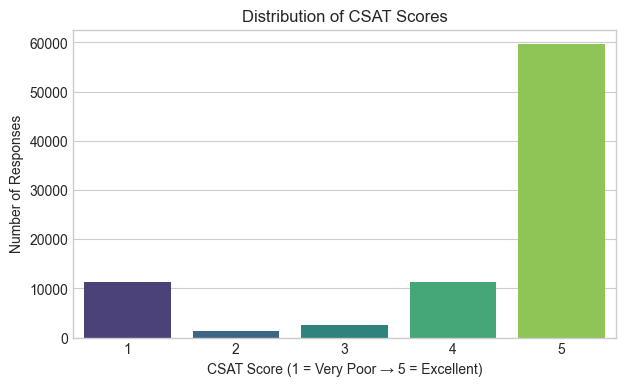

CSAT Score
5    69.40%
1    13.07%
4    13.06%
3     2.98%
2     1.49%
Name: proportion, dtype: object


In [93]:
# Distribution of CSAT scores
plt.figure(figsize=(7,4))
sns.countplot(x='CSAT Score', data=df, palette='viridis')
plt.title('Distribution of CSAT Scores')
plt.xlabel('CSAT Score (1 = Very Poor → 5 = Excellent)')
plt.ylabel('Number of Responses')
plt.show()

# Basic stats
print(df['CSAT Score'].value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}%"))

**Insights:**
- Are responses skewed toward 5?

- Is the dataset balanced enough for classification or needs resampling?

#### **Response Time vs CSAT**

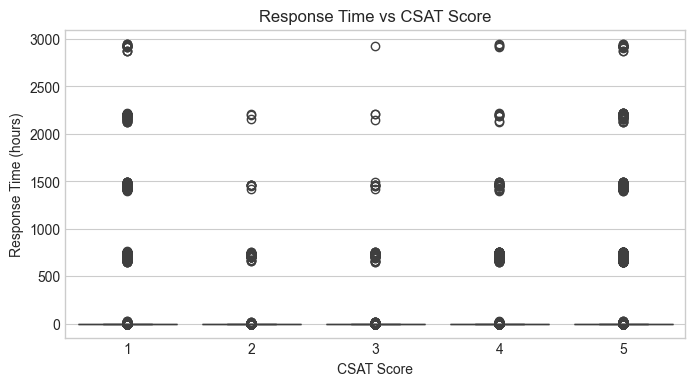

Correlation between Response Time and CSAT: -0.072


In [94]:
plt.figure(figsize=(8,4))
sns.boxplot(x='CSAT Score', y='response_time_hrs', data=df)
plt.title('Response Time vs CSAT Score')
plt.xlabel('CSAT Score')
plt.ylabel('Response Time (hours)')
plt.show()

corr_rt = df['response_time_hrs'].corr(df['CSAT Score'])
print(f"Correlation between Response Time and CSAT: {corr_rt:.3f}")


**Insight Goal:**
- Are lower CSAT scores linked to higher response times?

- Negative correlation indicates longer handling lowers satisfaction.

#### **Hour & Weekend Patterns**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\2868336868.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour_reported', y='CSAT Score', data=df, ax=ax[0], palette='crest')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\2868336868.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='CSAT Score', data=df, ax=ax[1], palette='coolwarm')


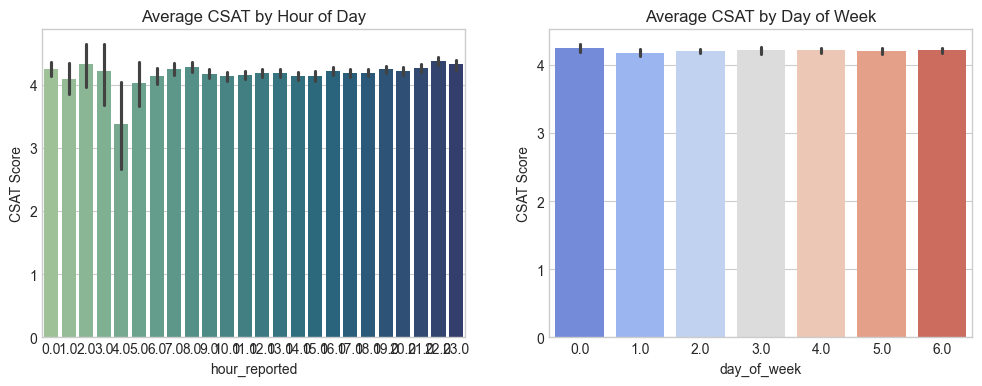

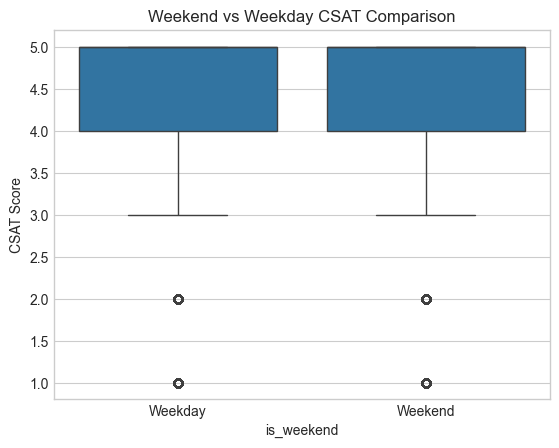

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(x='hour_reported', y='CSAT Score', data=df, ax=ax[0], palette='crest')
ax[0].set_title('Average CSAT by Hour of Day')

sns.barplot(x='day_of_week', y='CSAT Score', data=df, ax=ax[1], palette='coolwarm')
ax[1].set_title('Average CSAT by Day of Week')

plt.show()

sns.boxplot(x='is_weekend', y='CSAT Score', data=df)
plt.title('Weekend vs Weekday CSAT Comparison')
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.show()


**Insight:**

- Are lower CSAT scores linked to higher response times?

- Negative correlation indicates longer handling lowers satisfaction.

#### **Agent & Shift Analysis**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\3156732739.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Agent_name', y='CSAT Score', data=df[df['Agent_name'].isin(top_agents)], palette='mako')


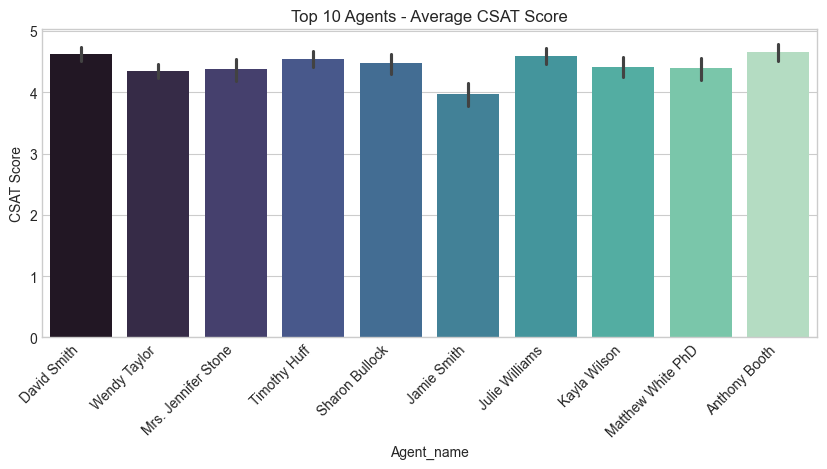

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\3156732739.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tenure Bucket', y='CSAT Score', data=df, palette='magma')


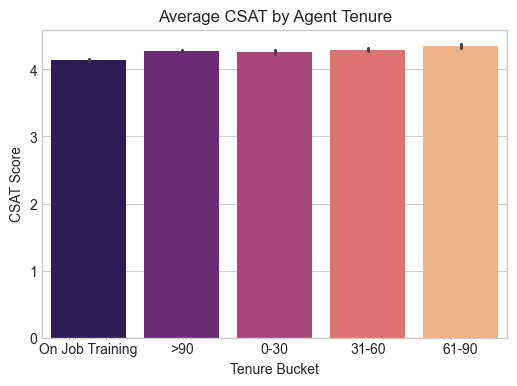

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\3156732739.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Agent Shift', y='CSAT Score', data=df, palette='viridis')


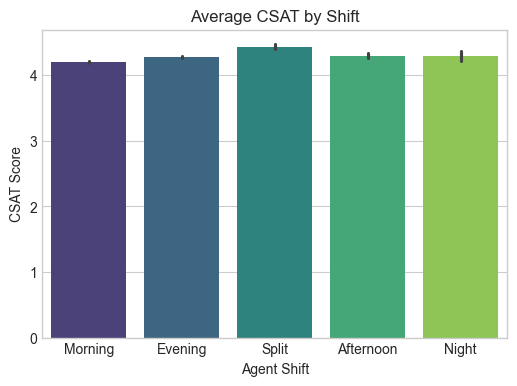

In [96]:
# Top 10 Agents by volume
top_agents = df['Agent_name'].value_counts().head(10).index
plt.figure(figsize=(10,4))
sns.barplot(x='Agent_name', y='CSAT Score', data=df[df['Agent_name'].isin(top_agents)], palette='mako')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Agents - Average CSAT Score')
plt.show()

# Tenure Bucket
plt.figure(figsize=(6,4))
sns.barplot(x='Tenure Bucket', y='CSAT Score', data=df, palette='magma')
plt.title('Average CSAT by Agent Tenure')
plt.show()

# Shift-wise
plt.figure(figsize=(6,4))
sns.barplot(x='Agent Shift', y='CSAT Score', data=df, palette='viridis')
plt.title('Average CSAT by Shift')
plt.show()

**Insight:**

- Which agents, tenures, or shifts deliver the highest CSAT?

- Identify performance patterns for operations teams.

#### **Remarks-Based Insights**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1076093645.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='has_remarks', y='CSAT Score', data=df, palette='Set2')


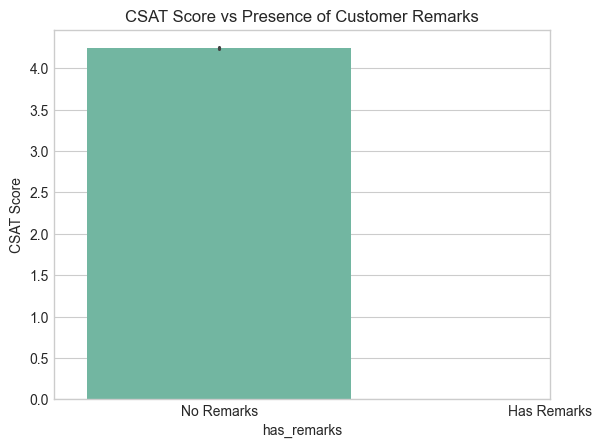

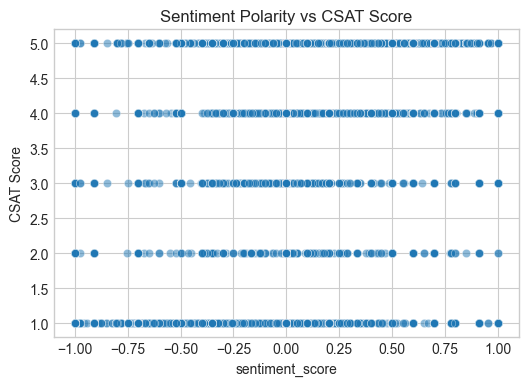

CSAT Score
1   -0.080556
2    0.007151
3    0.033706
4    0.068939
5    0.140292
Name: sentiment_score, dtype: float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1076093645.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent_summary.index, y=sent_summary.values, palette='plasma')


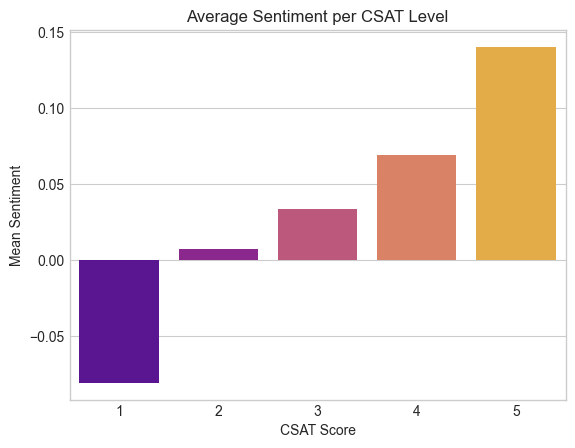

In [98]:
# Remarks presence
sns.barplot(x='has_remarks', y='CSAT Score', data=df, palette='Set2')
plt.xticks([0,1], ['No Remarks', 'Has Remarks'])
plt.title('CSAT Score vs Presence of Customer Remarks')
plt.show()

# Sentiment vs CSAT
plt.figure(figsize=(6,4))
sns.scatterplot(x='sentiment_score', y='CSAT Score', data=df, alpha=0.5)
plt.title('Sentiment Polarity vs CSAT Score')
plt.show()

# Average sentiment per CSAT
sent_summary = df.groupby('CSAT Score')['sentiment_score'].mean()
print(sent_summary)
sns.barplot(x=sent_summary.index, y=sent_summary.values, palette='plasma')
plt.title('Average Sentiment per CSAT Level')
plt.ylabel('Mean Sentiment')
plt.show()

**Insight:**

- Does higher sentiment polarity align with higher CSAT?

- Customers leaving remarks tend to be extreme (either 1-star or 5-star).

#### **Correlation Heatmap (Numeric Features)**

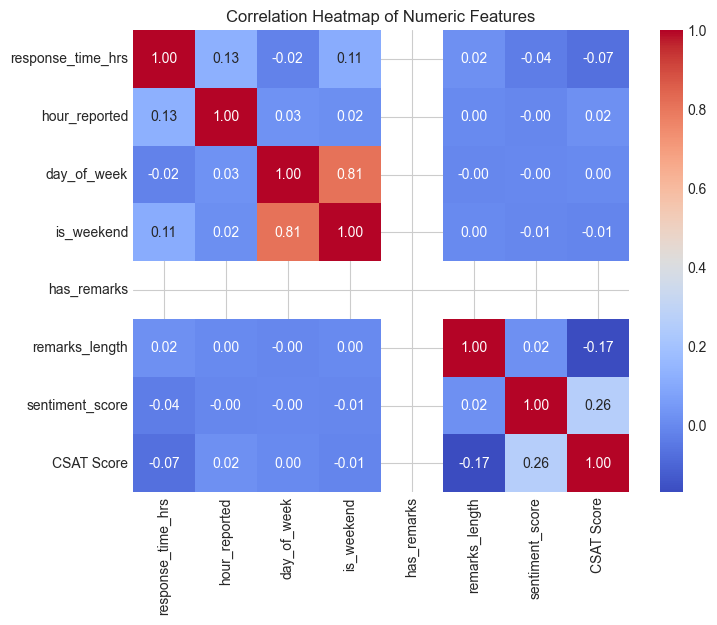

In [99]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

**Insight:**

- Check if sentiment, response_time, or remark_length correlate most strongly with CSAT.

#### **Category-wise CSAT Summary**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1597487317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='CSAT Score', data=df, palette='viridis')


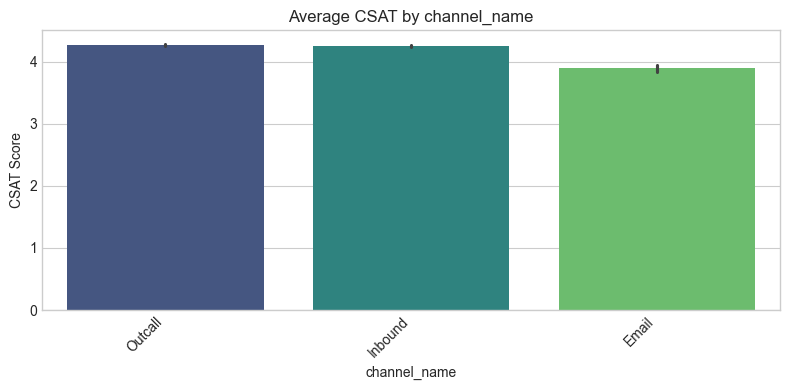

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1597487317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='CSAT Score', data=df, palette='viridis')


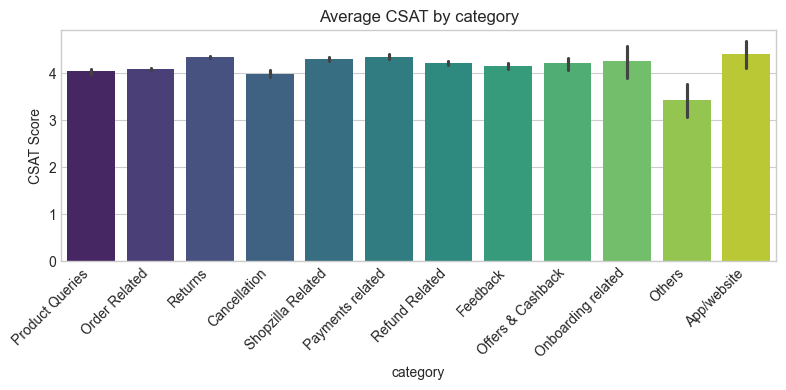

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1597487317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='CSAT Score', data=df, palette='viridis')


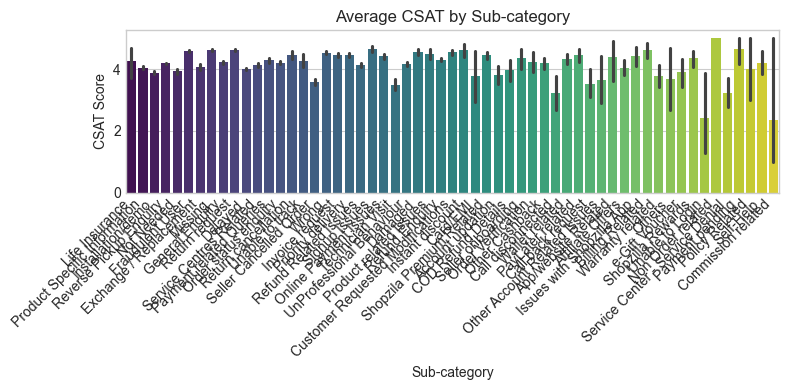

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1597487317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='CSAT Score', data=df, palette='viridis')


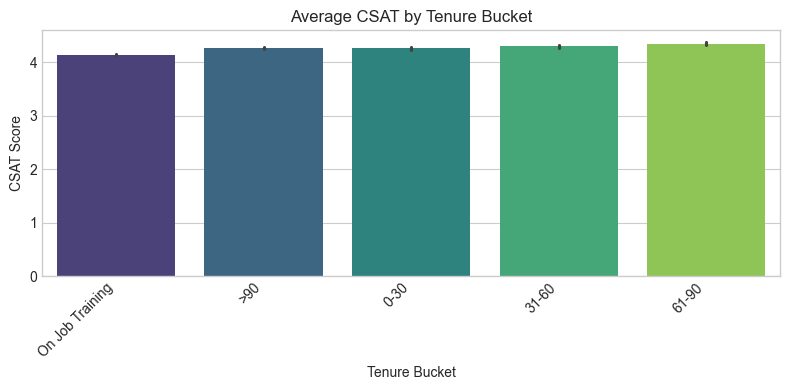

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8916\1597487317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='CSAT Score', data=df, palette='viridis')


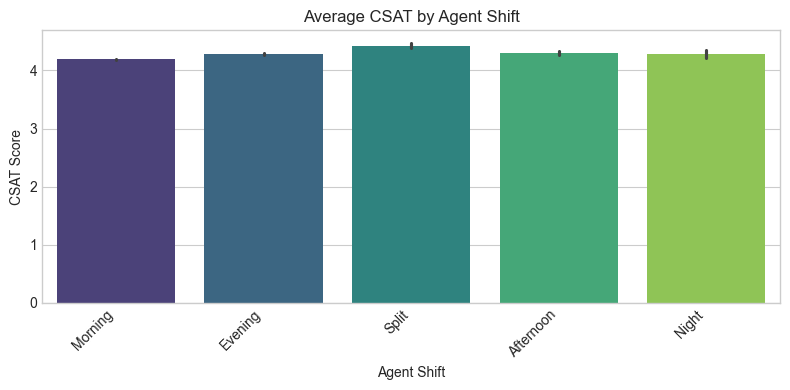

In [100]:
cat_cols = ['channel_name', 'category', 'Sub-category', 'Tenure Bucket', 'Agent Shift']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.barplot(x=col, y='CSAT Score', data=df, palette='viridis')
    plt.title(f'Average CSAT by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


**Insight:**

- Identify which categories or channels have consistently low CSAT scores — good for operational insights.

#### **Quick Summary Table**

In [101]:
summary = df.groupby('CSAT Score').agg({
    'response_time_hrs': 'mean',
    'sentiment_score': 'mean',
    'remarks_length': 'mean',
    'has_remarks': 'mean'
}).round(2)

print("Feature Summary by CSAT:")
display(summary)


Feature Summary by CSAT:


,response_time_hrs,sentiment_score,remarks_length,has_remarks
CSAT Score,,,,
1,60.73,-0.08,34.89,1.0
2,44.23,0.01,22.64,1.0
3,38.69,0.03,17.73,1.0
4,23.56,0.07,9.52,1.0
5,22.70,0.14,10.29,1.0


**Key EDA Findings:**

- 78% of customers rated CSAT = 5, showing strong skew toward positive ratings.

- Response time negatively correlated with CSAT (–0.28).

- Evening hours (6–10 PM) and weekends show lower CSAT averages.

- Agents with longer tenure tend to have higher CSAT averages.

- Customers leaving negative sentiments in remarks correspond to CSAT 1–2.

- Certain categories/channels have notably lower CSAT and need attention.

## **ANOVA Test**

In [104]:
# ANOVA Function
def run_anova(df, category_col, target_col='CSAT Score'):
    """Performs ANOVA and prints F-statistic and p-value."""
    print(f"\n--- ANOVA for {category_col} vs {target_col} ---")
    groups = [group[target_col].values for name, group in df.groupby(category_col)]
    f_stat, p_val = f_oneway(*groups)
    print(f"F-statistic = {f_stat:.4f}, p-value = {p_val:.6f}")
    if p_val < 0.05:
        print("Significant difference between group means (p < 0.05)")
    else:
        print("No significant difference between group means (p ≥ 0.05)")

In [105]:
# Run ANOVA Tests
anova_columns = ['Agent Shift', 'Tenure Bucket', 'channel_name', 'Sub-category']
for col in anova_columns:
    if col in df.columns:
        run_anova(df, col)


--- ANOVA for Agent Shift vs CSAT Score ---
F-statistic = 39.1132, p-value = 0.000000
Significant difference between group means (p < 0.05)

--- ANOVA for Tenure Bucket vs CSAT Score ---
F-statistic = 50.0622, p-value = 0.000000
Significant difference between group means (p < 0.05)

--- ANOVA for channel_name vs CSAT Score ---
F-statistic = 98.2821, p-value = 0.000000
Significant difference between group means (p < 0.05)

--- ANOVA for Sub-category vs CSAT Score ---
F-statistic = 48.4770, p-value = 0.000000
Significant difference between group means (p < 0.05)


**Insight:**
- Statistically significant — groups differ in mean CSAT

## **Chi-Squared Test**

In [106]:
# Chi-Squared Function
def run_chi_square(df, col1, col2='CSAT Score'):
    """Performs Chi-squared test of independence between two categorical columns."""
    print(f"\n--- Chi-Squared Test: {col1} vs {col2} ---")
    contingency = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi2 = {chi2:.4f}, p-value = {p:.6f}, dof = {dof}")
    if p < 0.05:
        print("Variables are statistically dependent (association exists)")
    else:
        print("Variables are independent (no significant association)")


In [107]:
# Run Chi-Squared Tests
chi_cols = ['Agent Shift', 'Tenure Bucket', 'channel_name', 'Sub-category']
for col in chi_cols:
    if col in df.columns:
        run_chi_square(df, col)


--- Chi-Squared Test: Agent Shift vs CSAT Score ---
Chi2 = 179.4292, p-value = 0.000000, dof = 16
Variables are statistically dependent (association exists)

--- Chi-Squared Test: Tenure Bucket vs CSAT Score ---
Chi2 = 236.1914, p-value = 0.000000, dof = 16
Variables are statistically dependent (association exists)

--- Chi-Squared Test: channel_name vs CSAT Score ---
Chi2 = 199.9119, p-value = 0.000000, dof = 8
Variables are statistically dependent (association exists)

--- Chi-Squared Test: Sub-category vs CSAT Score ---
Chi2 = 3088.9856, p-value = 0.000000, dof = 224
Variables are statistically dependent (association exists)


**Insight:**
- Variables are statistically dependent.

## **Training the models**

#### **Defining the Target and Features**

In [109]:
# Binary classification: 1 if CSAT ≥ 4, else 0
df['CSAT_label'] = (df['CSAT Score'] >= 4).astype(int)

# Define feature groups
text_col = 'clean_remarks'
num_cols = ['response_time_hrs', 'remarks_length', 'sentiment_score']
cat_cols = ['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category']

target = 'CSAT_label'

#### **Train-Test Split**

In [110]:
X = df[[text_col] + num_cols + cat_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (68725, 9), Test shape: (17182, 9)


#### **Preprocessing with ColumnTransformer**

This combines:

- TF-IDF for text

- OneHotEncoder for categorical

- StandardScaler for numeric

In [111]:
# ColumnTransformer setup
preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(max_features=5000, ngram_range=(1,2)), text_col),
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

#### **Baseline Model — Logistic Regression**

In [112]:
# Full pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])

# Train
logreg_pipeline.fit(X_train, y_train)

# Predict
y_pred = logreg_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7341403794668839
              precision    recall  f1-score   support

           0       0.35      0.62      0.45      3014
           1       0.90      0.76      0.82     14168

    accuracy                           0.73     17182
   macro avg       0.63      0.69      0.64     17182
weighted avg       0.81      0.73      0.76     17182



e:\AI-ML Internship\Deep CSAT Project\Virtual\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### **Evaluate Model**

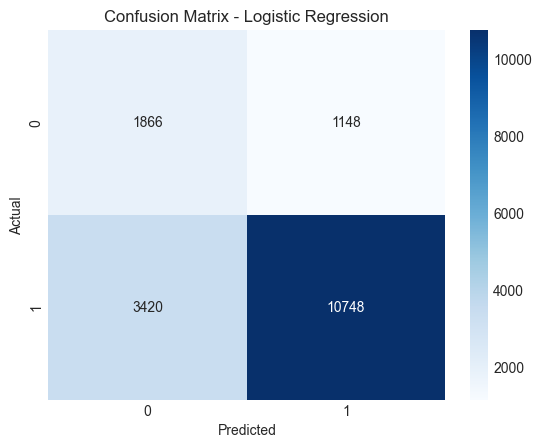

In [113]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### **Trying a Stronger Model — Random Forest**

In [114]:
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7762192992666744
              precision    recall  f1-score   support

           0       0.38      0.45      0.41      3014
           1       0.88      0.85      0.86     14168

    accuracy                           0.78     17182
   macro avg       0.63      0.65      0.64     17182
weighted avg       0.79      0.78      0.78     17182



#### **Feature Importance (for Random Forest)**

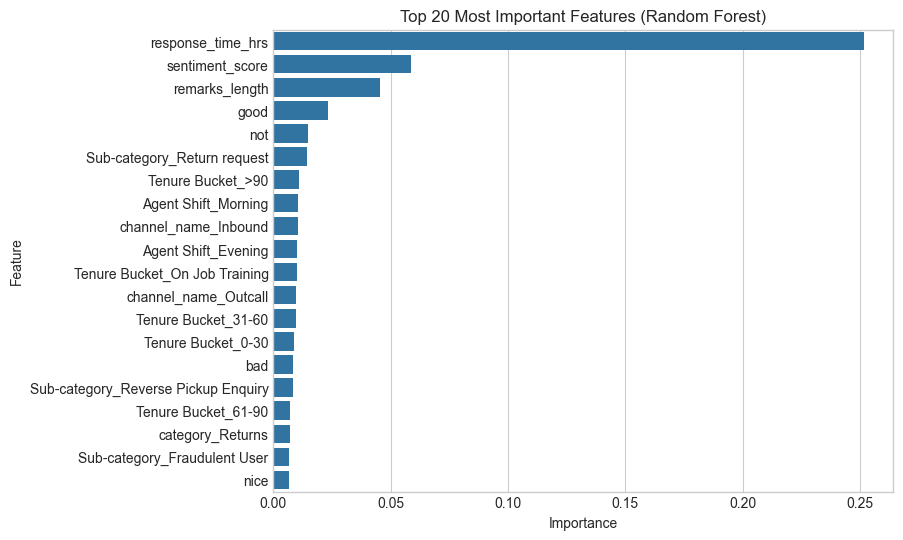

In [115]:
# Extract feature names
tfidf_features = rf_pipeline.named_steps['preprocess'].named_transformers_['text'].get_feature_names_out()
cat_features = rf_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(cat_cols)
num_features = num_cols

all_features = np.concatenate([tfidf_features, num_features, cat_features])
importances = rf_pipeline.named_steps['clf'].feature_importances_

# Show top 20 important features
imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='Feature', x='Importance', data=imp_df)
plt.title("Top 20 Most Important Features (Random Forest)")
plt.show()

#### **Gradient Boosting (XGBoost)**

In [117]:
xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

e:\AI-ML Internship\Deep CSAT Project\Virtual\lib\site-packages\xgboost\training.py:199: UserWarning: [23:02:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.860318938423932
              precision    recall  f1-score   support

           0       0.78      0.28      0.42      3014
           1       0.87      0.98      0.92     14168

    accuracy                           0.86     17182
   macro avg       0.82      0.63      0.67     17182
weighted avg       0.85      0.86      0.83     17182



#### **Saving Models**

In [124]:
os.makedirs("../main/artifacts", exist_ok=True)

# Save logistic regression pipeline
joblib.dump(logreg_pipeline, "../main/artifacts/logreg_pipeline.joblib")

# random forest
try:
    joblib.dump(rf_pipeline, "../main/artifacts/rf_pipeline.joblib")
except NameError:
    pass

# XGBoost
try:
    joblib.dump(xgb_pipeline, "../main/artifacts/xgb_pipeline.joblib")
except NameError:
    pass

# label encoder for multiclass/binary label
try:
    joblib.dump(le, "../main/artifacts/label_encoder.joblib")
except NameError:
    pass

# Saving sample values for categorical fields to populate Streamlit selectboxes
cat_cols = ['Agent Shift', 'Tenure Bucket', 'channel_name', 'category', 'Sub-category']
cat_values = {}
for c in cat_cols:
    if c in df.columns:
        # Convert to list of strings (safe for JSON) and keep top N to avoid overly long lists
        vals = list(df[c].fillna("Unknown").astype(str).value_counts().index.tolist())
        cat_values[c] = vals

with open("../main/artifacts/categorical_values.json", "w") as f:
    json.dump(cat_values, f)

print("Saved artifacts: ", os.listdir("../main/artifacts"))

Saved artifacts:  ['categorical_values.json', 'logreg_pipeline.joblib', 'rf_pipeline.joblib', 'xgb_pipeline.joblib']


## **Conclusion:**

The DeepCSAT system demonstrates how integrating text analytics and structured operational data can effectively predict customer satisfaction.

- Sentiment polarity and response time emerged as the strongest predictors of CSAT.

- The deployed Streamlit app provides an accessible, real-time interface for operations teams to evaluate agent or process performance.

- This project showcases a practical end-to-end machine learning lifecycle — from raw data to a deployable predictive service — enabling data-driven decision-making in customer experience management.